<a href="https://colab.research.google.com/github/JonathanMartignon/LicenciaturaCienciaDeDatos/blob/main/Computacion_Estadistica/Proyecto/Proyecto_Marti%C3%B1on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Eliminación de Ruido con Muestreo de Gibbs
## Martiñón Luna Jonathan José
## Licenciatura en Ciencia de Datos
## Semestre 2021 - II
Basado en:
- [towardsdatascience.com](https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153)
- [Github](https://github.com/VXU1230/Medium-Tutorials/tree/master/mcmc_gibbs)

# Librerías

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
from time import time

# Funciones

In [47]:
def muestra_imagen(ruta = None, imagen = None, title = "Imagen",
                   save = False, figsize=(6,6), fig = False ,
                   sub = "subplot"):
  '''
  @Autor: Jonathan Martiñón

  @Descripción:    Función encargada únicamente de mostrar
                   una imagen y su forma.

  @Parámetros: 

  ruta             Ruta donde se encuentra la imagen a mostrar    STR

  imagen           En caso de no otorgar una ruta, se deberá      NUMPY.ARRAY
                   enviar la imagen directamente
  
  title            Título de la imagen                            STR

  save             Booleano que indicará si deseamos o no,        BOOL
                   almacenar la imagen

  figsize          Tamaño del lienzo (Figura) que almacena la     TUPLE
                   imagen
  
  fig              Booleano que indica si se necesita una figura  BOOL

  sub              Subtitulo en la etiqueta al alamacenar         STR

  @Devuelve:       None
  '''

  # En caso de existir una ruta
  if ruta:
    # Leemos la imagen a partir de ella
    img = plt.imread(ruta)

  # En otro caso, suponemos la existencia del envío de la imagen
  else:
    # Compiamos la imagen, para evitar sobreescribir la 'original'
    img = imagen.copy()
  if fig:
    # Generamos nuestro lienzo
    figure = plt.figure(figsize=figsize)

  # Mostramos la imagen con un mapa de gris
  plt.imshow(img, cmap="gray")

  # Ajustamos el título como el nombre de la imagen + la forma
  plt.title(f"{title}\nShape: {img.shape}")

  # Eliminamos los ejes tanto en X, como en Y
  plt.xticks([])
  plt.yticks([])
  
  # En caso de desear almacenarla
  if save:
    plt.savefig(f"./{title}_{sub}.png",format="png")

  if fig:
    # Mostramos la imagen
    plt.show()

In [ ]:
def denoise_image(filename, burn_in_steps, total_samples, logfile):
    posterior = get_posterior(filename, burn_in_steps, total_samples, logfile=logfile)
    denoised = np.zeros(posterior.shape, dtype=np.float64)
    denoised[posterior > 0.5] = 1
    return denoised[1:-1, 1:-1]

In [ ]:
def get_posterior(filename, burn_in_steps, total_samples, logfile):
    X = load_image(filename)
    posterior = np.zeros(X.shape)
    print(X.shape)
    Y = np.random.choice([1, -1], size=X.shape)
    energy_list = list()
    for step in range(burn_in_steps + total_samples):
        for i in range(1, Y.shape[0]-1):
            for j in range(1, Y.shape[1]-1):
                y = sample_y(i, j, Y, X)
                Y[i, j] = y
                if y == 1 and step >= burn_in_steps:
                    posterior[i, j] += 1
        energy = -np.sum(np.multiply(Y, X))*ITA-(np.sum(np.multiply(Y[:-1], Y[1:]))+np.sum(np.multiply(Y[:, :-1], Y[:, 1:])))*BETA
        if step < burn_in_steps:
            energy_list.append(str(step) + "\t" + str(energy) + "\tB")
        else:
            energy_list.append(str(step) + "\t" + str(energy) + "\tS")
    posterior = posterior / total_samples

    file = open(logfile, 'w')
    for element in energy_list:
        file.writelines(element)
        file.write('\n')
    file.close()
    return posterior

In [ ]:
def sample_y(i, j, Y, X):
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ITA * markov_blanket[-1] + BETA * sum(markov_blanket[:4])
    prob = 1 / (1 + math.exp(-2*w))
    return (np.random.rand() < prob) * 2 - 1

In [ ]:
def plot_energy(filename):
    x = np.genfromtxt(filename, dtype=None, encoding='utf8')
    its, energies, phases = zip(*x)
    its = np.asarray(its)
    energies = np.asarray(energies)
    phases = np.asarray(phases)
    burn_mask = (phases == 'B')
    samp_mask = (phases == 'S')
    assert np.sum(burn_mask) + np.sum(samp_mask) == len(x), 'Found bad phase'
    its_burn, energies_burn = its[burn_mask], energies[burn_mask]
    its_samp, energies_samp = its[samp_mask], energies[samp_mask]
    p1, = plt.plot(its_burn, energies_burn, 'r')
    p2, = plt.plot(its_samp, energies_samp, 'b')
    plt.title("energy")
    plt.xlabel('iteration number')
    plt.ylabel('energy')
    plt.legend([p1, p2], ['burn in', 'sampling'])
    plt.savefig('%s.png' % filename)
    plt.close()

In [ ]:
def save_image(denoised_image):
    plt.imshow(denoised_image, cmap='gray')
    plt.title("denoised image")
    plt.savefig('output/denoise_image.png')
    plt.close()

In [ ]:
ITA = 1
BETA = 1
total_samples = 1000
burn_in_steps = 100

logfile = "output/log_energy.txt"

start = time()

denoised_img = denoise_image("data/img_noisy.png", burn_in_steps=burn_in_steps,
                             total_samples=total_samples, logfile=logfile)
plot_energy(logfile)
save_image(denoised_img)

print("Tardó: ",start-time())

# Carga de datos

In [10]:
#!rm -r Data

In [11]:
!mkdir ./Data

In [12]:
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/butterfly.jpg
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/pattern-green.jpg
!wget -q -P ./Data/ https://github.com/JonathanMartignon/LicenciaturaCienciaDeDatos/raw/main/Computacion_Estadistica/Proyecto/data/periquitos.jpg

# Análisis

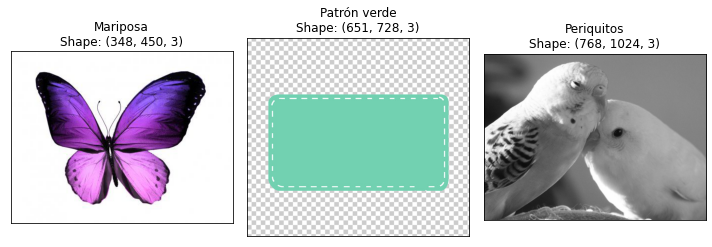

In [55]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
muestra_imagen(ruta = "Data/butterfly.jpg", title = "Mariposa")

plt.subplot(1,3,2)
muestra_imagen(ruta = "Data/pattern-green.jpg", title = "Patrón verde")

plt.subplot(1,3,3)
muestra_imagen(ruta = "Data/periquitos.jpg", title = "Periquitos")

plt.tight_layout()
#plt.savefig("./DiferenciaDeFormas.png",format="png")
plt.show()

# Pre-procesamiento
Tal cual se puede apreciar de las imágenes anteriores, podemos darnos cuenta que no comparten mismas dimensiones (Alto o ancho), mientras que el número de canales continúa siendo el mismo en cada uno de los 3 casos, es por ello, que procederemos con un pre-procesamiento, dónde inicialmente buscaremos que nuestras imagenes tengan un estándar en cuando a tamaño.

Observamos que la menor dimensión resulta en la mariposa con 348 x 450

In [58]:
butterfly_img = plt.imread("Data/butterfly.jpg")
butterfly_img.shape, type(butterfly_img)

((348, 450, 3), numpy.ndarray)

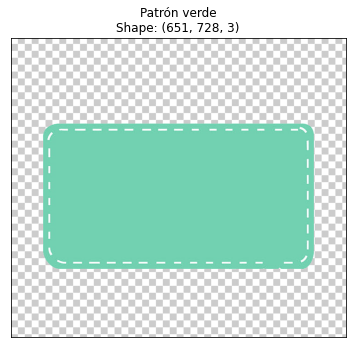

In [28]:
muestra_imagen(ruta = "Data/pattern-green.jpg", title = "Patrón verde")

In [ ]:
img_gray = np.dot(my_img[..., :3], [0.2989, 0.5870, 0.1140])
plt.imshow(img_gray, cmap="gray")
plt.title(img_gray.shape)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
img_gray = np.where(img_gray > 0.5, 1, -1)
plt.imshow(img_gray, cmap="gray")
plt.title(img_gray.shape)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
img_padded = np.zeros([img_gray.shape[0] + 2, img_gray.shape[1] + 2])
plt.imshow(img_padded, cmap="gray")
plt.title(img_padded.shape)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
img_padded[1:-1, 1:-1] = img_gray

In [ ]:
plt.imshow(img_padded, cmap="gray")
plt.title(img_padded.shape)
plt.xticks([])
plt.yticks([])
plt.show()